# Binary classification from CSV file with validation and test sets
In this example we'll look at a more reaslistic example for applying neural networks: training a classifier to predict signal and background events using the data from the [HiggsML Kaggle challenge](https://www.kaggle.com/c/higgs-boson)
1. Data is imported from CSV format
1. Data is preprocessed
1. A Neural network with multiple inputs is built and trained
1. The resulting classifier is evaluated on validation data and test data
1. The model is interpreted via feature importance

We'll use the version of the data available from the [CERN OpenData portal](http://opendata.cern.ch/record/328?ln=en), however it is also available from [Kaggle](https://www.kaggle.com/c/higgs-boson). Alternatively, uncomment and run the cell below:

In [1]:
#!mkdir data
#!wget -O data/atlas-higgs-challenge-2014-v2.csv.gz http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
#!gunzip data/atlas-higgs-challenge-2014-v2.csv.gz

### Basic Modules

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Union, Optional, Tuple
from rfpimp import importances
from collections import OrderedDict
import os

import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import ForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, Embedding, Reshape, Concatenate
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
from pathlib import Path
PATH = Path('data/')

## Data preparation

### Data import from CSV file 
Read file into a pandas dataframe. Pandas is a great (and fast) module for dealing with columnar data.

In [4]:
data = pd.read_csv(PATH/'atlas-higgs-challenge-2014-v2.csv')

In [5]:
data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


We'll rename some of the columns (personally I like to have anything based generator level information prepended with 'gen'). We'll aslo cut down the training data to use only what was available for the challenge.

In [6]:
data.drop(columns=['Weight'], inplace=True)
data['Label'] = data['Label'].map({'s':1, 'b':0})
data.rename(index=str, columns={"KaggleWeight": "gen_weight", 'PRI_met': 'PRI_met_pt', 'Label':'gen_target'}, inplace=True)

df = pd.DataFrame(data.loc[data.KaggleSet == 't'])
df.drop(columns=['KaggleSet'], inplace=True)
    
test = pd.DataFrame(data.loc[(data.KaggleSet == 'b') | (data.KaggleSet == 'v')])
test['private'] = 0
test.loc[(data.KaggleSet == 'v'), 'private'] = 1
test.drop(columns=['KaggleSet'], inplace=True)

Lets check some of the features. The transverse mass can be expected to provide some decent separation betwee signal and background. Note how we can apply temporary cuts to the DataFrame and return individual columns.

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


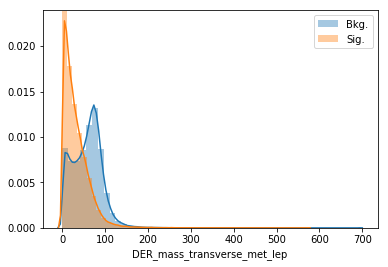

In [7]:
sns.distplot(df.loc[df.gen_target == 0, 'DER_mass_transverse_met_lep'], label='Bkg.')
sns.distplot(df.loc[df.gen_target == 1, 'DER_mass_transverse_met_lep'], label='Sig.')
plt.legend();

So there is still quite a bit of overlap between the two classes. Let's hope our NN can improve things a bit.

### Preprocessing
Having imported the data, we now need to further process it into form suitable for training the classifier.

We can start by moving a Cartesian coordinate system; the HEP standard of $p_T,\ \eta,\ \phi$ can be a bit tricky, since $\phi$ is cyclical in nature, and $\eta$ is highly non-linear. Additionally, since the class of each event is invariant under transformations of the absolute orientation of each event, we can remove several symetries in the data by rotating each event to have the same orientation.

`proc_event` has options to set all events to have `ref_vec_0` at $\phi=0$ and be always in the positive $\eta$ region. The remaining symmetry of transverse reflection can be fixed by setting `ref_vec_1` to be in the positive $\phi$ region. The vectors can then transformed into Cartesian system via `use_cartesian` flag. The original vectors are automatically dropped, but can be kept if added to `keep_feat`. It can sometimes be useful to keep the absolute amount of $p_T^{\mathrm{miss}}$, since this is now non-linear combination of $p_x^{\mathrm{miss}}$ and $p_y^{\mathrm{miss}}$.

Additionally, we'll process the default values for missing jets (-999.0) to NaNs to avoid them biasing our preprocessing.

In [8]:
print([f for f in df.columns])

['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_pt', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt', 'gen_target', 'gen_weight']


In [9]:
def delta_phi(arr_a:np.ndarray, arr_b:np.ndarray) -> float:
    df = pd.DataFrame()
    df['dphi'] = arr_b-arr_a
    while len(df[df.dphi > np.pi]) > 0:  df.loc[df.dphi > np.pi, 'dphi']  -= 2*np.pi
    while len(df[df.dphi < -np.pi]) > 0: df.loc[df.dphi < -np.pi, 'dphi'] += 2*np.pi
    return df.dphi.values

def fix_event_phi(df:pd.DataFrame, ref_vec:str) -> None:
    '''Rotate event in phi such that ref_vec is at phi == 0'''
    for v in get_vecs(df.columns):
        if v != ref_vec: df[f'{v}_phi'] = delta_phi(df[f'{ref_vec}_phi'], df[f'{v}_phi'])
    df[f'{ref_vec}_phi'] = 0

def get_vecs(feats:List[str], strict:bool=True) -> List[str]:
    '''Get list of vector from list of features.
    if strict, return only vectors with all coordinates present in feature list'''
    low = [f.lower() for f in feats]
    all_vecs = [f for f in feats if (f.lower().endswith('_pt') or f.lower().endswith('_phi') or f.lower().endswith('_eta')) or 
                                    (f.lower().endswith('_px') or f.lower().endswith('_py')  or f.lower().endswith('_pz'))]
    if not strict: return set([v[:v.rfind('_')] for v in all_vecs])
    vecs = [v[:v.rfind('_')] for v in all_vecs if (f'{v[:v.rfind("_")]}_pt'.lower() in low and f'{v[:v.rfind("_")]}_phi'.lower() in low) or 
                                                  (f'{v[:v.rfind("_")]}_px'.lower() in low and f'{v[:v.rfind("_")]}_py'.lower()  in low)]
    return set(vecs)

def to_cartesian(df:pd.DataFrame, vec:str, drop:bool=False) -> None:
    '''Convert vector to Cartesian coordinates inplace, optionally dropping old pT,eta,phi features'''
    z = f'{vec}_eta' in df.columns
    try:
        pt = df[f'{vec}_pT']
        pt_name = f'{vec}_pT'
    except KeyError:
        pt = df[f'{vec}_pt']
        pt_name = f'{vec}_pt'

    if z: eta = df[f'{vec}_eta']  
    phi = df[f'{vec}_phi']
    df[f'{vec}_px'] = pt*np.cos(phi)
    df[f'{vec}_py'] = pt*np.sin(phi)
    if z: df[f'{vec}_pz'] = pt*np.sinh(eta)
    if drop:
        df.drop(columns=[pt_name, f"{vec}_phi"], inplace=True)
        if z: df.drop(columns=[f"{vec}_eta"], inplace=True)

def fix_event_z(df:pd.DataFrame, ref_vec:str) -> None:
    '''Flip event in z-axis such that ref_vec is in positive z-direction'''
    if f'{ref_vec}_eta' in df.columns:
        cut = (df[f'{ref_vec}_eta'] < 0)
        for v in get_vecs(df.columns):
            try: df.loc[cut, f'{v}_eta'] = -df.loc[cut, f'{v}_eta'] 
            except KeyError: print(f'eta component of {v} not found')
    else:
        cut = cut = (df[f'{ref_vec}_pz'] < 0)
        for v in get_vecs(df.columns):
            try: df.loc[cut, f'{v}_pz'] = -df.loc[cut, f'{v}_pz']
            except KeyError: print(f'pz component of {v} not found')


def fix_event_y(df:pd.DataFrame, ref_vec_0:str, ref_vec_1:str) -> None:
    '''Flip event in y-axis such that ref_vec_1 has a higher py than ref_vec_0'''
    if f'{ref_vec_1}_phi' in df.columns:
        cut = (df[f'{ref_vec_1}_phi'] < 0)
        for v in get_vecs(df.columns):
            if v != ref_vec_0: df.loc[cut, f'{v}_phi'] = -df.loc[cut, f'{v}_phi'] 
    else:
        cut = (df[f'{ref_vec_1}_py'] < 0)
        for v in get_vecs(df.columns):
            if v != ref_vec_0: df.loc[cut, f'{v}_py'] = -df.loc[cut, f'{v}_py']
                
def event_to_cartesian(df:pd.DataFrame, drop:bool=False, ignore:List[str]=[]) -> None:
    '''Convert entire event to Cartesian coordinates, except vectors in ignore.
    Optionally, drop old pT,eta,phi features'''
    for v in get_vecs(df.columns):
        if v not in ignore: to_cartesian(df, v, drop=drop)


def proc_event(df:pd.DataFrame, fix_phi:bool=False, fix_y=False, fix_z=False, use_cartesian=False,
               ref_vec_0:str=None, ref_vec_1:str=None, keep_feats=[], default_vals=[]) -> None:
    '''Pass data through conversions and drop uneeded columns'''
    df.replace([np.inf, -np.inf]+default_vals, np.nan, inplace=True)
    for f in keep_feats: df[f'{f}keep'] = df[f'{f}']
    
    if fix_phi:
        print(f'Setting {ref_vec_0} to phi = 0')
        fix_event_phi(df, ref_vec_0)
        if fix_y:
            print(f'Setting {ref_vec_1} to positve phi')
            fix_event_y(df, ref_vec_0, ref_vec_1)
    if fix_z:
        print(f'Setting {ref_vec_0} to positive eta')
        fix_event_z(df, ref_vec_0) 
    if use_cartesian:
        print("Converting to use_cartesian coordinates")
        event_to_cartesian(df, drop=True)
    if   fix_phi and not use_cartesian: df.drop(columns=[f"{ref_vec_0}_phi"], inplace=True)
    elif fix_phi and     use_cartesian: df.drop(columns=[f"{ref_vec_0}_py"], inplace=True)
    
    for f in keep_feats:
        df[f'{f}'] = df[f'{f}keep']
        df.drop(columns=[f'{f}keep'], inplace=True)

In [10]:
proc_event(df, fix_phi=True, fix_y=True, fix_z=True, ref_vec_0='PRI_lep', ref_vec_1='PRI_tau', 
           use_cartesian=True, default_vals=[-999.0], keep_feats=['PRI_met_pt'])
proc_event(test, fix_phi=True, fix_y=True, fix_z=True, ref_vec_0='PRI_lep', ref_vec_1='PRI_tau', 
           use_cartesian=True, default_vals=[-999.0], keep_feats=['PRI_met_pt'])

Setting PRI_lep to phi = 0
Setting PRI_tau to positve phi
Setting PRI_lep to positive eta
eta component of PRI_met not found
Converting to use_cartesian coordinates
Setting PRI_lep to phi = 0
Setting PRI_tau to positve phi
Setting PRI_lep to positive eta
eta component of PRI_met not found
Converting to use_cartesian coordinates


For quick access, we'll define here all the sets of features we'll later want use.

In [11]:
targ_feat = 'gen_target'
gen_feats = [f for f in df.columns if 'gen_' in f]
misc_feats = ['EventId']
wgt_feat = 'gen_weight'
cat_feats = ['PRI_jet_num']
cont_feats = [f for f in df.columns if f not in gen_feats+cat_feats+misc_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

1 ['PRI_jet_num']
29 ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_pt']


Note that we'll be treating the number of jets in the event `PRI_jet_num` as a categorical feature; whilst the number of jets has some numerical meaning (an event with 2 jets contains more jets than an event with none), this feature can instead be treated as identifying different sub-classes of event, in which case a *1-jet event* has no numerical comparison to a *3-jet event*. Basically, this means we'll treat the feature a bit differently to the normal, continuous features.

In [12]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
df.columns[df.isna().any()].tolist()

['DER_mass_MMC',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_subleading_px',
 'PRI_jet_subleading_py',
 'PRI_jet_subleading_pz',
 'PRI_jet_leading_px',
 'PRI_jet_leading_py',
 'PRI_jet_leading_pz']

In [14]:
test.columns[test.isna().any()].tolist()

['DER_mass_MMC',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_subleading_px',
 'PRI_jet_subleading_py',
 'PRI_jet_subleading_pz',
 'PRI_jet_leading_px',
 'PRI_jet_leading_py',
 'PRI_jet_leading_pz']

We've got some NaNs in the data, however this is due to non-existent jets, float precision, and algorithm non-convergence. Later we'll use `np.nan_to_num` to replace them with real numbers.

#### Train-validation split 
In previous examples, we've evaluated are model on the same data it was trained with, however we also saw that NNs do not extrapolate well and can easily overfit to the training data. For this challenge we have a test set, which originally did not have labels and would be used to determine the final performance of our solution for the competition. However if we wanted to change the model and tune it a bit, we would have to have some extra data to check the model performance on, otherwise we may well overfit to the testing data. This extra set is commonly called the *validation dataset*. Basically, model performance can be evaluated on data which was not used for training (shows how the model generalises to unseen data), and the model can be tuned without the danger of overfitting to the test data.

The data also contains a mis-match between the number of signal and background events, which could lead the classifier to be biased into classifying one class better than the other. By creating a normalised version of the event weights, the loss during training can be reweighted to account for this difference. We;ll do this before splitting the training data, so that the losses of training and validation are of comparable scale.

In [15]:
df['gen_orig_weight'] = df['gen_weight']
df.loc[df.gen_target == 0, 'gen_weight'] /= np.sum(df.loc[df.gen_target == 0, 'gen_weight'])
df.loc[df.gen_target == 1, 'gen_weight'] /= np.sum(df.loc[df.gen_target == 1, 'gen_weight'])

In [16]:
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.gen_target, random_state=1111)

A go to guide for validation set size is about 20% of your training data, but feel free to experiment. We also perform a *stratified* split based on the event class; the ratios of signal to background in the training and validation sets should be equal.

It is important that our validation set matches the test set as closely as possible. For our case, the training and testing data are probably just a random subsamples of the same original dataset, so random splitting for validation  should work well, however you might later come across problems where the test set set different to the training set (e.g. in time-series data), in which case you may want to remove features which are affected by this difference.

`check_val_set` runs some random forests to try and predict the originating datasets of the events, and then returns the area under the ROC curve for the classifiers. Ideally this should be 0.5, indicating it can only do as well as random guessing. Training and inference use weights to account for the fact that the datasets may have uneven populations.

In [17]:
def get_rf_feat_importance(rf:ForestRegressor, inputs:pd.DataFrame, targets:np.ndarray, weights:Optional[np.ndarray]=None) -> pd.DataFrame:
    '''Wrapper function for rfpimp which checks correct version is installed'''
    return importances(rf, inputs, targets, features=inputs.columns, sample_weights=weights).reset_index()

def check_val_set(val:Union[pd.DataFrame,np.ndarray], test:Union[pd.DataFrame,np.ndarray]) -> None:
    '''Method to check validation set suitability by seeing whether random forests can predict whether events belong to one dataset or the other.'''
    if not isinstance(val, pd.DataFrame): 
        val  = pd.DataFrame(np.nan_to_num(val))
        test = pd.DataFrame(np.nan_to_num(test))
    else:
        val  = pd.DataFrame(np.nan_to_num(val.values),  columns=val.columns)
        test = pd.DataFrame(np.nan_to_num(test.values), columns=test.columns)

    df_0 = test
    df_1 = val
    df_0['gen_target'] = 0
    df_1['gen_target'] = 1
    df_0['gen_weight'] = 1/len(df_0)
    df_1['gen_weight'] = 1/len(df_1)

    df = df_0.append(df_1, ignore_index=True).sample(frac=1)
    df_trn, df_val = df[:len(df)//2], df[len(df)//2:]
    train_feats = [f for f in df_trn.columns if 'gen_' not in f]

    m = RandomForestClassifier(n_estimators=40, min_samples_leaf=25, n_jobs=-1)
    m.fit(df_trn[train_feats], df_trn['gen_target'], df_trn['gen_weight'])
    auc = roc_auc_score(df_val['gen_target'], m.predict(df_val[train_feats]), sample_weight=df_val['gen_weight'])
    fi = get_rf_feat_importance(m, df_val[train_feats], df_val['gen_target'],
                                df_val['gen_weight']).sort_values(['Importance'], ascending=False).reset_index()
    print(f"\nAUC for test-validation discrimination = {auc}")
    print("Top 10 most important features are:")
    print(fi[:min(10, len(fi))])

In [18]:
check_val_set(val_df[train_feats], test[train_feats])


AUC for test-validation discrimination = 0.49999984042346535
Top 10 most important features are:
   index                      Feature  Importance
0      0                   PRI_lep_pz    0.002503
1      1                PRI_met_sumet    0.002285
2      2                   PRI_lep_px    0.001523
3      3                   PRI_met_pt    0.000979
4      4                   PRI_met_px    0.000979
5      5       DER_met_phi_centrality    0.000871
6      6           DER_deltar_tau_lep    0.000871
7      7                     DER_pt_h    0.000871
8      8           PRI_jet_leading_pz    0.000762
9      9  DER_mass_transverse_met_lep    0.000762


Looks like there is no way to tell the validation set apart from the testing set

#### Final preprocessing
The network weights will use initialisation schemes which expect the inputs to be unit Gaussian. We'll use sklearn pipelines to package transformations which alter the data to have mean zero and standard deviation one. Note that we only apply these transformations to the continuous features, and only fit the transformations to the training data before applying them to all datasets. 

In [19]:
input_pipe = Pipeline([('norm_in', StandardScaler(with_mean=True, with_std=True))])
input_pipe.fit(train_df[cont_feats])

Pipeline(memory=None,
     steps=[('norm_in', StandardScaler(copy=True, with_mean=True, with_std=True))])

In [20]:
train_df[cont_feats] = input_pipe.transform(train_df[cont_feats])
val_df[cont_feats] = input_pipe.transform(val_df[cont_feats])
test[cont_feats] = input_pipe.transform(test[cont_feats])

/Users/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/giles/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

As mentioned before, we'll be treating the categorical features a bit differently to the continuous ones. We need to have some way of encoding the value into something the network can interpret. Since the value of a categorical feature (its *code*) doesn't matter, we can transform them to start from zero and increase incrementaly. This makes them easier to encode, however we also need to make sure the validation (and test) sets receive the same transformaitions as the training set.

`proc_cats` does this and returns dictionaries of the both the mapping that was applied, and the cardinality (number of unique values) of each feature.

In [21]:
def proc_cats(train_df:pd.DataFrame, cat_feats:List[str], 
              val_df:Optional[pd.DataFrame]=None, test_df:Optional[pd.DataFrame]=None) -> Tuple[OrderedDict,OrderedDict]:
    '''Process categorical features in train_df to be valued 0->cardinality-1.
    Applies same transformation to validation adn testing data.
    Returns transformation maps and cardinalities'''
    cat_maps = OrderedDict()
    cat_szs = OrderedDict()
    for feat in cat_feats:
        cat_maps[feat] = {}
        vals = sorted(set(train_df[feat]))
        cat_szs[feat] = len(vals)
        if val_df is not None:
            if sorted(set(val_df[feat])) != vals:
                raise Exception(f"Feature {feat} declared categorical, but validation set contains categories different to the training set")
        if test_df is not None:
            if sorted(set(val_df[feat])) != vals:
                raise Exception(f"Feature {feat} declared categorical, but testing set contains categories different to the training set")
        
        for i, val in enumerate(vals):
            train_df.loc[train_df[feat] == val, feat] = i
            if val_df is not None: val_df.loc[val_df[feat] == val, feat] = i
            if test_df is not None: test_df.loc[test_df[feat] == val, feat] = i
            cat_maps[feat][i] = val
    return cat_maps, cat_szs

In [22]:
cat_maps, cat_szs = proc_cats(train_df, cat_feats, val_df, test)
cat_maps, cat_szs

/Users/giles/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(OrderedDict([('PRI_jet_num', {0: 0, 1: 1, 2: 2, 3: 3})]),
 OrderedDict([('PRI_jet_num', 4)]))

So as it turns out the values of `PRI_jet_num` were already sequential from zero to one.

## Train classifier

Now we're ready to begin training the network-based classifier, but we have yet to decide how to encode our categorical feature. A common approach is *one-hot encoding*, where a binary vector is used with the number of elements equal to the feature cardinality. A value can then be represented by setting one of the elements to one, e.g. an event with two jets could be represented by 0010, or zero jets by 1000.

This requires us to have as many inputs to our model as there are unique numbers in each categorical feature; fine when we just have one feature with a cardinality of four, but what is we had 10 features with hundreds of unique values? That's a lot of extra inputs!

[Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737) offers an alternative solution: each code of a categorical feature corresponds to a row in and $n\times m$ matrix called an *embedding*, where $n$ is the cardinality of the feature and $m$ is the pre-chosen *embedding size*, and $m<n$. Effectively, rather than encoding a feature of cardinality $n$ as a one-hot vector of length $n$, it is encoded as a vector of floats of length $m$. The embedding size can be tuned, but useful rule of thumb is min(50, (cardinality+1)//2).

These floats are then treated as parameters of the network meaning they can be updated; effectively, during training the embedding matrix learns the optimal way of representing the feature in a compact fashion whilst still allowing a rich representation of the feature.


In the below example of encoding the day of the week, Monday is represented by (0.3,0.9,0.4,0.7), rather than (1,0,0,0,0,0,0) e.g. by four inputs rather than seven. 
<img src="imgs/embedding.png" width="250">

Building this model will use a hybrid approach of the class and functionally approaches; a `Sequential` model build by the class-based approach can then be used as a transformation in the functional approach.

We build sub-networks for embedding each categorical feature (just the one in our case) and then concatenate the embedding outputs with the continuous inputs. This concatenation operation is likely to mean that the signals in the network are no longer close to unit-Gaussian, therefore we'll include a `BatchNormalization` layer. This applies a transformation to the signals to return them to unit-Gaussian. We can then pass the normalised signal through dense layers as normal.

In [23]:
def build_model(n_cont_in:int, n_cat_in:int, cat_szs:List[int]) -> Model:
    #Continuous inputs
    cont_in = Input(shape=(n_cont_in,))
    
    #Categorical embeddings
    embedds = []
    for cat_sz in cat_szs:
        m = Sequential()
        sz = min((cat_sz+1)//2, 50)  # embedding size uses a rule of thumb
        m.add(Embedding(cat_sz, sz, input_length=1))  # Embeddings are normally used of recurrent networks, hence need to specify an input length
        m.add(Reshape(target_shape=(sz,)))  # Need to reshape because reasons
        embedds.append(m)
        
    merged = Concatenate()([cont_in]+[e.output for e in embedds])
    merged = BatchNormalization()(merged)
    for _ in range(4): merged = Dense(100, activation='relu', kernel_initializer='he_normal')(merged)
    merged = Dense(1, activation='sigmoid')(merged)
    
    return Model(inputs=[cont_in]+[e.input for e in embedds], outputs=merged)

In [24]:
model = build_model(len(cont_feats), len(cat_feats), [cat_szs[f] for f in cat_szs])

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 2)         8           embedding_1_input[0][0]          
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 29)           0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2)            0           embedding_1[0][0]                
__________________________________________________________________________________________________
concatenat

The optimiser parameters I've set using prior experience with this dataset and architecture. Sadly, not enough time to go into details.

In [26]:
model.compile(Adam(lr=2e-3, epsilon=1e-8), loss='binary_crossentropy')

We'll pass our validation data to the model during fitting. The data isn't used for training, but instead to monitor the performance and generalisation of the model. Training a network normally involves three stages: undertraining, where performance on training and validation data is bad but improving; optimal performance, where performance on validation data is as good as it will be; and over training, where performance on training data continues to improve, but validation performance either stays the same or gets worse (generalisation to unseen data worsens).

It's necessary to see this point of overtraining to know that are model has reached and bypassed its optimal performance (is not underfitting), however we want to use the model in the state it was in when it was perfoming optimally. To do this we can use `Callback` classes to perform actions during training.

`EarlyStopping` will stop training automatically if the validation loss has not improved for a set number of epochs (its `patience`); we can set a really high value of `epochs` in training to ensure the model over trains, but does not take ages to finish training.

`ModelCheckpoint` will save a copy of the model whenever it improves on the validation data. We can then reload this model after training to get back to the state of optimal performance. 

In [27]:
os.makedirs('tmp', exist_ok=True)
callbacks = [EarlyStopping(patience=10, verbose=True), ModelCheckpoint('tmp/best.h5', save_best_only=True, save_weights_only=True)]

Since we have multiple inputs to the model, we need to pass a list of arrays as inputs.

In [28]:
hist = model.fit(x=[np.nan_to_num(train_df[cont_feats])]+[train_df[f].values for f in cat_feats], y=train_df.gen_target, sample_weight=train_df.gen_weight,
                 validation_data=([np.nan_to_num(val_df[cont_feats])]+[val_df[f].values for f in cat_feats], val_df.gen_target, val_df.gen_weight),
                 batch_size=256, callbacks=callbacks, epochs=50)

Train on 200000 samples, validate on 50000 samples
Epoch 1/50
200000/200000 [==============================] - 3s 14us/step - loss: 2.9201e-06 - val_loss: 2.6982e-06
Epoch 2/50
200000/200000 [==============================] - 2s 11us/step - loss: 2.6984e-06 - val_loss: 2.6664e-06
Epoch 3/50
200000/200000 [==============================] - 2s 11us/step - loss: 2.6592e-06 - val_loss: 2.6504e-06
Epoch 4/50
200000/200000 [==============================] - 2s 11us/step - loss: 2.6275e-06 - val_loss: 2.6759e-06
Epoch 5/50
200000/200000 [==============================] - 2s 11us/step - loss: 2.6178e-06 - val_loss: 2.6146e-06
Epoch 6/50
200000/200000 [==============================] - 2s 11us/step - loss: 2.5929e-06 - val_loss: 2.5970e-06
Epoch 7/50
200000/200000 [==============================] - 2s 11us/step - loss: 2.5830e-06 - val_loss: 2.6043e-06
Epoch 8/50
200000/200000 [==============================] - 2s 11us/step - loss: 2.5758e-06 - val_loss: 2.6240e-06
Epoch 9/50
200000/200000 [===

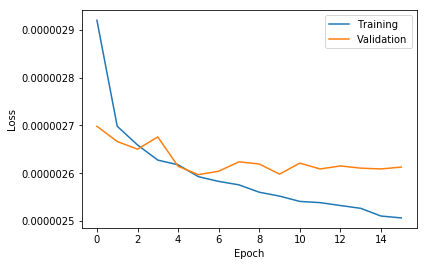

In [29]:
plt.plot(range(len(hist.history['loss'])), np.array(hist.history['loss']), label='Training')
plt.plot(range(len(hist.history['val_loss'])), np.array(hist.history['val_loss']), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss');

As expected, our validation loss decreases, reaches a plateau, and the starts get worse, whereas the training loss continually improves. This improvement is artificial an does not generalise to unseen data (otherwise it would be reflected in the validation loss). Since we want to apply our model to unseen data, we should reload the model where the validation loss was lowest.

In [30]:
model.load_weights('tmp/best.h5')

## Validation scoring
We have a value for the loss of the validation data, however the Higgs challenge involves maximising the *Approximate Median Significance* (a number which approximately indicates the statistical significance of the signal/background hypothesis test. Significance greater than five indicates discovery of the Higgs boson).

Computing the AMS requires cutting on the classifier prediction, throwing away data below the cut and passing the weights of true and false positives to a complicated formula. Maximising the AMS involves varying this cut and checking the corresponding AMS.

In [31]:
val_df['pred'] = model.predict([np.nan_to_num(val_df[cont_feats])]+[val_df[f].values for f in cat_feats])

/Users/giles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
def calc_ams(s:float, b:float, br:float=0, unc_b:float=0) -> float:
    '''Compute Approximate Median Significance for signal (background) weight s (b),
    fractional systemtatic uncertainty unc_b, and offset br'''
    if b == 0: return -1
    if not unc_b:
        radicand = 2*((s+b+br)*np.log(1.0+s/(b+br))-s)
    else:
        sigma_b_2 = np.square(unc_b*b)
        radicand = 2*(((s+b)*np.log((s+b)*(b+sigma_b_2)/((b**2)+((s+b)*sigma_b_2))))-(((b**2)/sigma_b_2)*np.log(1+((sigma_b_2*s)/(b*(b+sigma_b_2))))))
    return np.sqrt(radicand) if radicand > 0 else -1

In [33]:
def ams_scan(df:pd.DataFrame, wgt_factor:float=1, br:float=0, syst_unc_b:float=0,
                   pred_name:str='pred', targ_name:str='gen_target', wgt_name:str='gen_weight') -> Tuple[float,float]:
    '''Determine optimum calc_ams and cut,
    wgt_factor used rescale weights to get comparable calc_amss
    sufferes from float precison - not recommended for final evaluation'''
    max_ams, threshold = 0, 0.0
    df = df.sort_values(by=[pred_name])
    s = np.sum(df.loc[(df[targ_name] == 1), wgt_name])
    b = np.sum(df.loc[(df[targ_name] == 0), wgt_name])

    for i, cut in enumerate(df[pred_name]):
        ams = calc_ams(max(0, s*wgt_factor), max(0, b*wgt_factor), br, syst_unc_b)
        if ams > max_ams: max_ams, threshold = ams, cut
        if df[targ_name].values[i]: s -= df[wgt_name].values[i]
        else:                            b -= df[wgt_name].values[i]        
    return max_ams, threshold

In the HiggsML challenge, prediction on the test set requires specifying whether each event is signal or background, meaning we need to apply a cut on our class prediction. We could simply scan across the events in the validation sample and see where the AMS is maximised, (not we apply a weight factor to account for the difference between our validation sample and the full training sample):

In [34]:
len(val_df)

50000

In [35]:
val_df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_lep_px,PRI_lep_pz,PRI_tau_px,PRI_tau_py,PRI_tau_pz,PRI_met_pt,gen_orig_weight,pred
213545,313545,-0.624062,0.682420,-0.202234,-0.321165,NaN,NaN,NaN,-0.484883,-0.696371,...,0.768635,-0.267791,-0.006585,-0.713692,0.870954,-0.256574,0.931122,-0.243755,2.563464,0.006032
225855,325855,0.516757,-0.097314,1.102178,-0.877414,NaN,NaN,NaN,2.046500,-0.752042,...,NaN,NaN,-0.718410,0.548523,-0.185284,-0.528814,-0.866449,-0.682538,6.605061,0.012267
51626,151626,NaN,1.602425,-0.979147,-0.882647,NaN,NaN,NaN,-1.474702,-0.766837,...,NaN,NaN,-0.003407,-0.649662,0.705449,0.146564,-0.231347,0.645734,2.082024,0.038576
180833,280833,NaN,0.991297,-0.451134,-0.451843,NaN,NaN,NaN,-0.739043,0.451082,...,NaN,NaN,0.099787,-0.043662,0.506119,0.186024,-0.462582,0.156317,2.235962,0.009929
45468,145468,-0.594403,-0.497205,-0.561894,-0.501034,NaN,NaN,NaN,0.378495,0.312016,...,NaN,NaN,-0.780336,-0.216827,-0.421457,-0.461467,-0.057606,-0.884742,1.681611,0.461196


`ams_scan` will run across a range of cuts and return the maximum AMS and its corresponding cut. Note that we have to use the original, unnormalised weight, and account for the fact that the validation set is a subsample of the full training data (`wgt_factor`).

In [36]:
ams, cut = ams_scan(val_df, br=10, wgt_factor=250000/50000, wgt_name='gen_orig_weight'); ams, cut

(3.604286764337133, 0.9113179445266724)

Not a bad result, would probably have got us in the third of the competition. We can also plot the distributions of signal and background.

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


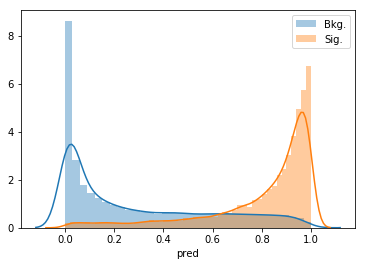

In [37]:
sns.distplot(val_df.loc[val_df.gen_target==0, 'pred'], label='Bkg.')
sns.distplot(val_df.loc[val_df.gen_target==1, 'pred'], label='Sig.')
plt.legend();

Looks good, both signal and background are peaking towards their respective targets with equal heights (unbiased classifier), and the distributions seem quite smooth.

## Test scoring

With the OpenData version of the data, we have a labelled test set, so we can evaluate our score without submitting to Kaggle. Of course we can't reoptimise our cut, so we'll use the one from the validation data and hope it generalises well.

In [38]:
def score_test_df(df:pd.DataFrame, cut:float, pred_name='pred'):
    accept = (df[pred_name] >= cut)
    signal = (df.gen_target == 1)
    bkg = (df.gen_target == 0)
    public = (df.private == 0)
    private = (df.private == 1)

    public_ams = calc_ams(np.sum(df.loc[accept & public & signal, 'gen_weight']),
                          np.sum(df.loc[accept & public & bkg, 'gen_weight']))

    private_ams = calc_ams(np.sum(df.loc[accept & private & signal, 'gen_weight']),
                           np.sum(df.loc[accept & private & bkg, 'gen_weight']))

    print("Public:Private AMS: {} : {}".format(public_ams, private_ams))    
    return public_ams, private_ams

In [39]:
test['pred'] = model.predict([np.nan_to_num(test[cont_feats])]+[test[f].values for f in cat_feats])

In [40]:
_ = score_test_df(test, cut, pred_name='pred')

Public:Private AMS: 3.5833441553268246 : 3.5536932225852382


## Interpretation - Feature importance
So we now have a model which is able to separate signal and background very well; one might very well be interested in what information the network is using to get a handle on the data classes.

A quick way is to evaluate which features are important to the model. This can be done by *feature permutation*. The performance of the model is first evaluated. Then for each feature sequentially a copy of the data is made, and the order of one of that feature is randomised such that its values no longer correspond to the other features in the data. The model model performance is revaluated on the shuffled data, and compared to the original score. If there is a large decrease in the score, then the feature which was randomised was very important in the model. If there is only a small decrease (or increase) in the score, then the feature was not important.

In [41]:
def get_nn_feat_importance(model:Model, df:pd.DataFrame, cont_feats:List[str], cat_feats:List[str]=[], wgt_name:Optional[str]=None) -> pd.DataFrame:
    '''Compute permutation importance of features used by a NN''' 
    weights = df[wgt_name] if wgt_name is not None else None
    nom = model.evaluate([np.nan_to_num(df[cont_feats])]+[df[f].values for f in cat_feats], df.gen_target, sample_weight=weights, verbose=False)
    scores = []
    for i in range(len(cont_feats)):
        x_cont = np.nan_to_num(df[cont_feats].values)
        x_cont[:,i] = sklearn.utils.shuffle(x_cont[:,i])
        scores.append(model.evaluate([x_cont]+[df[f].values for f in cat_feats], df.gen_target, sample_weight=weights, verbose=False))
    for i in range(len(cat_feats)):
        x_cat = [df[f].values for f in cat_feats]
        x_cat[i] = sklearn.utils.shuffle(x_cat[i])
        scores.append(model.evaluate([x_cont]+x_cat, df.gen_target, sample_weight=weights, verbose=False))
    scores = (np.array(scores)-nom)/nom
    fi = pd.DataFrame({'Feature':cont_feats+cat_feats, 'Importance':scores}).sort_values('Importance', ascending=False).reset_index(drop=True)
    
    print("Top ten most important features:\n", fi[:min(len(fi), 10)])
    fig, ax = plt.subplots(figsize=(21, 12))
    fi.plot('Feature', 'Importance', 'barh', ax=ax, legend=False)
    ax.set_xlabel('Importance via feature permutation', fontsize=16, color='black')
    ax.set_ylabel('Feature', fontsize=16, color='black')
    plt.xticks(fontsize=16, color='black')
    plt.yticks(fontsize=16, color='black')
    plt.show()
    return fi

Top ten most important features:
                        Feature  Importance
0         DER_pt_ratio_lep_tau    0.408202
1                   PRI_tau_px    0.326111
2                 DER_mass_vis    0.308321
3           DER_deltar_tau_lep    0.251124
4  DER_mass_transverse_met_lep    0.246944
5                  PRI_jet_num    0.239542
6                   PRI_met_pt    0.175222
7                   PRI_tau_py    0.157472
8                 DER_mass_MMC    0.091184
9                   PRI_met_py    0.090712


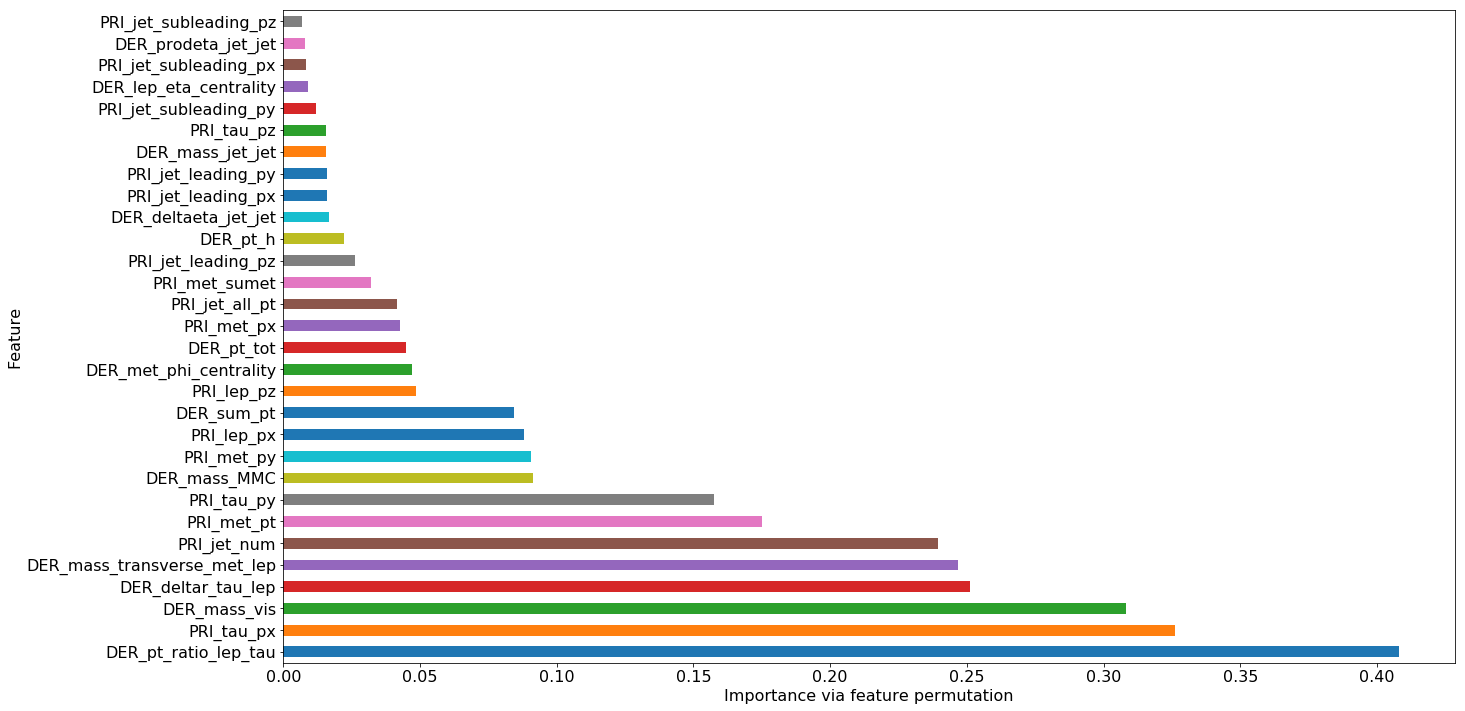

In [42]:
_ = get_nn_feat_importance(model, train_df.sample(5000, weights='gen_weight'), cont_feats, cat_feats, wgt_name='gen_weight')

Looks like a healthy spread of importances; although one feature seems to be more important than the rest, there are several other features which also have almost as high importances. The network is making good use of the data rather than being overly reliant on a single feature (which could be mismodeled by simulation). The network is also making decent use of the low-level information, not just the physics-inspired high-level features.